# Segunda aula: From Model to Production

Na segunda aula do FastAI, tem como objetico melhorar a capacidade de indentificação do modelo e subir o modelo como uma aplicação, é demonstrado para o aluno como plotar as maiores perdas, a matriz de confusão do modelo e como limpar imagens que podem trazer algum tipo de problema para o modelo.

* Esse artigo tera como objetivo categorizar o tipo de gado de uma fazenda por exemplo. Antes de começar é necessário importar algumas bibliotecas para facilitar o processo de desenvolvimento do projeto proposto, as bibliotecas principais que serão utilizadas são a do próprio FastAI e a do DuckDuckGo (tem como objetivo permitir pesquisar fotos).

In [30]:
# Importar a biblioteca OS permite utilizar comandos para instalar blibliotecas como é feito a seguir.
import os
!pip install -Uqq fastai duckduckgo_search

# Dessas bibliotecas importadas será utilizado apenas algumas funcionalidades, portanto para não sobrecarregar o modelo, 
# iremos importas apenas funcionalidades selecionadas. 

from duckduckgo_search import ddg_images
from fastcore.all import *

# 1. Buscando e armazenando fotos 

Apos importar bibliotecas é possível então pesquisar por imagens relacionadas ao projeto. No meu caso irei pesquisar imagens de alguns tipos de gado.

In [32]:
# Essa função terá como objetivo pesquisar por imagens deacordo com o termo que for sugerido para buscar no DuckDuckGo

def buscar_imagens(term, max_images=200):
    print(f"Buscando por '{term}'")
# ddg_images é uma funcionalidade da biblioteca importada.
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Definida a função responsável por buscar fotos no DuckDuckGo, é possível agora pesquisar fotos de cachorros e gatos!

Será criado um loop com o objetivo de salvar em uma pasta as imagens encontradas e que foram feito o dowload. 


In [33]:
# Termos que serão utilizados na busca.
searches = 'Angus', 'Hereford', 'Charolais', 'Simmental', 'Red Angus'
# , 'Limousin', 'Gelbvieh', 'Brangus', 'Beefmaster', 'Salers', 'Shorthorn', 'Maine-Anjou', 'Brahman', 'Chianina', 'Texas Longhorn', 'Santa Gertrudis', 'Braunvieh', 'Corriente', 'Tarentaise', 'Holstein', 'Jersey', 'Guernsey', 'Brown Swiss'
# O caminho da pasta que será gerada para armazenar
path = Path('cattle_type')
# Importando função sleep para não sobrecarregar o servidor
from time import sleep
from fastai.vision.all import *

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=buscar_imagens(f'{o} cattle photo'))
    sleep(3)
    resize_images(path/o, max_size=400, dest=path/o)

Buscando por 'Angus cattle photo'
Buscando por 'Hereford cattle photo'
Buscando por 'Charolais cattle photo'
Buscando por 'Simmental cattle photo'
Buscando por 'Red Angus cattle photo'


# 2. Hora de treinar o modelo

Apos ser feito o dowload das imagens e o seu armazenamento devemos treinar o modelo para diferenciar um gato de um cachorro e vice e versa. Para isso será necessário antes retirar imagens quebradas, ao fazer a pesquisa e o dowload de imagens pelo DuckDuckGo algumas das imagens encontradas podem ter tido problemas ao ser feito o dowload. Logo, para resolver esse possível problema eleminaremos imagens que não tiveram êxito no dowload.

In [34]:
failed = verify_images(get_image_files(path))
# Após identificar as imagens que tiveram um problema ao realizar o dowload elas serão eliminadas.
failed.map(Path.unlink)
# Irá demonstrar a quatidade de imagens que falharam.
len(failed)

10

Após eleminar possíveis erros nos dowloads, é necessário um DataLoader que é um objeto que possui uma série de dados (nesse caso imagens) para treinar o modelo e validações que são utilizadas para verificar o grau de acertividade. A biblioteca do FastAI facilita esse processo com a utilização do chamado DataBlock que possui uma série de parâmetros para deixar ainda mais configurável o treinamento do modelo.

Os parâmetros que iremos passar estão definindo:
1. O input do DataBlock será imagens e o output será cada categoria.
2. As imagens utilizadas serão das que foram feito dowload.
3. Irá definir 20% das imagens para serem usadas como validação do modelo.
4. A definição da imagem(qual tipo de gado).
5. Define o tamanho da imagem para 192x192.

Uma rede neural não entende como uma imagem funciona, portanto ao trocar o degrau de uma imagem o modelo não reconhece. Logo, ao treinar uma rede neural, o ideal é mudar suavemente o local da imagem e o degrau com o objetivo de melhorar a capacidade de reconhecimento do modelo.
Com isso em mente será usado o RandomResizedCrop, que irá alcançar esse comportamento descrito, e uma imagem de 224px com o aug_trasform padrão.

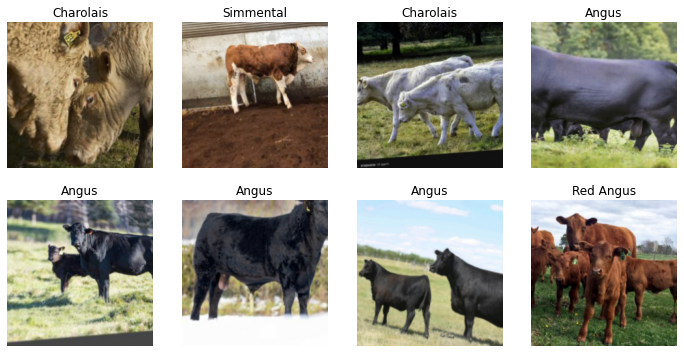

In [35]:
cattle = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cattle.dataloaders(path)
dls.show_batch(max_n=8)

Agora que os dados para ser feito o treinamento foram devidamente configurados estamos prontos para treinar o modelo. O modelo mais famoso é o resnet18. Esse modelo é definido por Yashvi Chandola e Papendra Kumar, no [Deep Learning for Chest Radiographs](https://www.sciencedirect.com/book/9780323901840/deep-learning-for-chest-radiographs) de 2021 como:
> The primary idea of ResNet is the use of jumping connections that are mostly referred to as shortcut connections or identity connections. These connections primarily function by hopping over one or multiple layers forming shortcuts between these layers. The aim of introducing these shortcut connections was to resolve the predominant issue of vanishing gradient faced by deep networks. These shortcut connections remove the vanishing gradient issue by again using the activations of the previous layer. These identity mappings initially do not do anything much except skip the connections, resulting in the use of previous layer activations. This process of skipping the connection compresses the network; hence, the network learns faster.

O **Learner** permite agrupar o DataBlock com o modelo que deve ser treinado e a métrica que será utilizada. Além disso a biblioteca do FastAI possui uma funcionalidade muito útil a **fine_tune**, essa função permite que de maneira simples você indique para modelos pré-treinados utilizarem boas práticas, ou seja irá pegar modelos pré-treinados, nesse caso o resnet18 e ajustar para o propósito desejado. Mais detalhes sobre o **fine_tune** podem ser encontrados [aqui](https://forums.fast.ai/t/understanding-fine-tuning/54142/2).

In [36]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.410712,0.657540,0.196864,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.765044,0.506863,0.146341,00:18
1,0.629992,0.399171,0.141115,00:17
2,0.527979,0.371963,0.111498,00:18
3,0.444790,0.344112,0.114983,00:19
4,0.347628,0.315831,0.108014,00:17
5,0.302844,0.312116,0.106272,00:18


Para facilitar a identificação de onde o modelo esta tendo mais problemas o FastAI disponibiliza a função plot_confusion_matrix, que irá demonstrar entre quais gados está a maior confusão.
Nessa matriz a diagonal representa os valores acertados do modelo e nos outros quadrados estão os erros e entre quais isso ocorre.

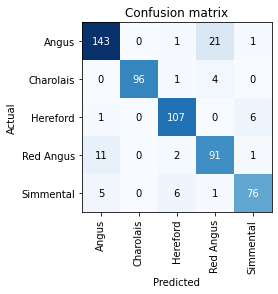

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Após plotar essa matrix, fica claro que o maior problema está entre identificar red angus e um angus, o que faz sentido pois a principal diferença entre eles é o tom mais avermelhado na cor do red angus. Outro tipo de gado que demonstra muitos problemas de identificação é o Simmental com quase todos os outros tipo, acredito que isso ocorra pois o Simmental não tem uma caracteristica tão diferenciada quanto os outros.

É muito útil ver onde ocorre os erros, se é um problema no dataset(imagens inválidas) ou do modelo(problema de luz). Para facilitar essa identificação ordenamos as imagens pela loss delas.
A loss é um numero que representa o grau de erro do modelo, quanto maior pior. Se o modelo estiver muito certo do tipo de imagem e errar o grau de erro é maior.

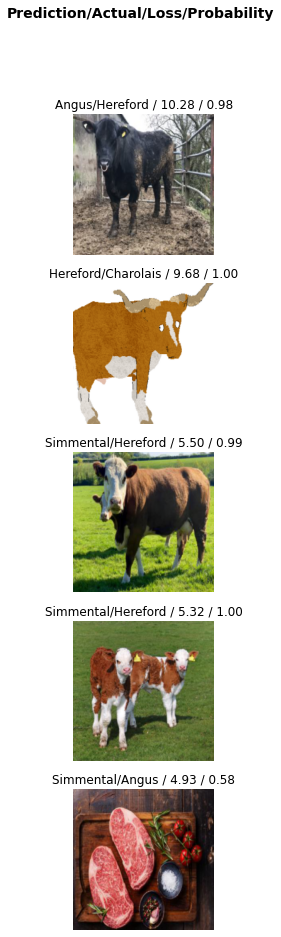

In [38]:
interp.plot_top_losses(5, nrows=5)

Após mostrar os principais erros podemos ver que existe alguns problemas de dataset(segunda foto) e tambem erros do modelo que não consegue interpretar a luz do ambiente por exemplo(foto 5).

Para resolver isso iremos eliminar algumas fotos que geram esses problemas com o ImageClassifierCleaner.

In [39]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

Após identificado as imagens para serem deletadas e as imagens que terão sua categoria deletada, os loops a seguir irão de fato fazer isso.

In [40]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Feito as mudanças após o data cleaner o modelo deve ser testado novamente.

In [41]:
dls = cattle.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.521968,0.690792,0.202091,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.726599,0.524392,0.179443,00:18
1,0.632132,0.505327,0.170732,00:18
2,0.506780,0.409522,0.125436,00:17
3,0.423069,0.352136,0.121951,00:19
4,0.360428,0.330633,0.108014,00:18
5,0.314817,0.325101,0.102787,00:18


É possível perceber que após retirar algumas imagens e mudar de categoria obteve-se um pequena melhora na qualidade do modelo. Acredito que se eu possuisse uma habilidade melhor de identificar cada tipo de gado seria visto uma melhora significativa.

Após concluido esse processo estamos prontos para testar o modelo!

Para fazer o deploy do modelo no hugging face o modelo será exportado usando a seguinte linha de código:

In [42]:
learn.path = Path('.')
learn.export()

# 3. Usando o modelo!

Fazendo o dowload de uma imagem de um Charolais.

Buscando por 'Charolais photos'


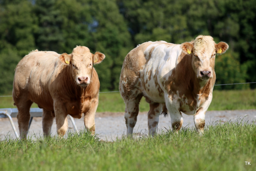

In [44]:
from fastdownload import download_url
from fastai.vision.all import *

urls = buscar_imagens('Charolais photos', max_images=1)
dest = 'cattle.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)


Testando modelo com imagem baixada anteriormente.

In [45]:
cattle_type,_,probs = learn.predict(PILImage.create('cattle.jpg'))
print(f"This is a: {cattle_type}.")
print(f"Probability is: {max(probs):.4f}")

This is a: Charolais.
Probability is: 0.9873


# 4. Fazendo Deploy do Modelo

Após exportar o modelo, como demonstrado acima, devemos baixar o arquivo pkl gerado. Feito isso é criada uma conta no Hugging Face e feito o upload para o repositório criado do export.pkl gerado aqui no Kaggle.

Em seguida devemos criar um arquivo do tipo app.py no repositório do Huggin Face utilizando o Gradio. Para fazer esse arquivo foi utilizado do seguinte código:

In [ ]:
import gradio as gr
from fastai.vision.all import *
import skimage 

learn = load_learner('export.pkl')

labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

title = "Cattle Type Classifier"
examples = ['angus.jpg', 'red_angus.jpg', 'simmetal.jpg', 'charolais.jpg', 'hereford.jpg']
interpretation='default'
enable_queue=True

gr.Interface(fn=predict,inputs=gr.inputs.Image(shape=(512, 512)),outputs=gr.outputs.Label(num_top_classes=5),title=title,examples=examples,interpretation=interpretation,enable_queue=enable_queue).launch()

Esse código carrega o modelo e utiliza do Gradio para gerar uma interface que irá ser lida pelo Hugging Face. Também deverá ser feito o upload dos arquivos .jpg que serão usados como exemplo padrão, no meu caso examples angus.jpg, red_angus.jpg, simmetal.jpg, charolais.jpg e hereford.jpg. E por último também deve ser criado um arquivo requirements.txt com as bibliotecas usadas, que foram: fastai e scikit-image.

Feita essas etapas foi feito o deploy do modelo desenvolvido:
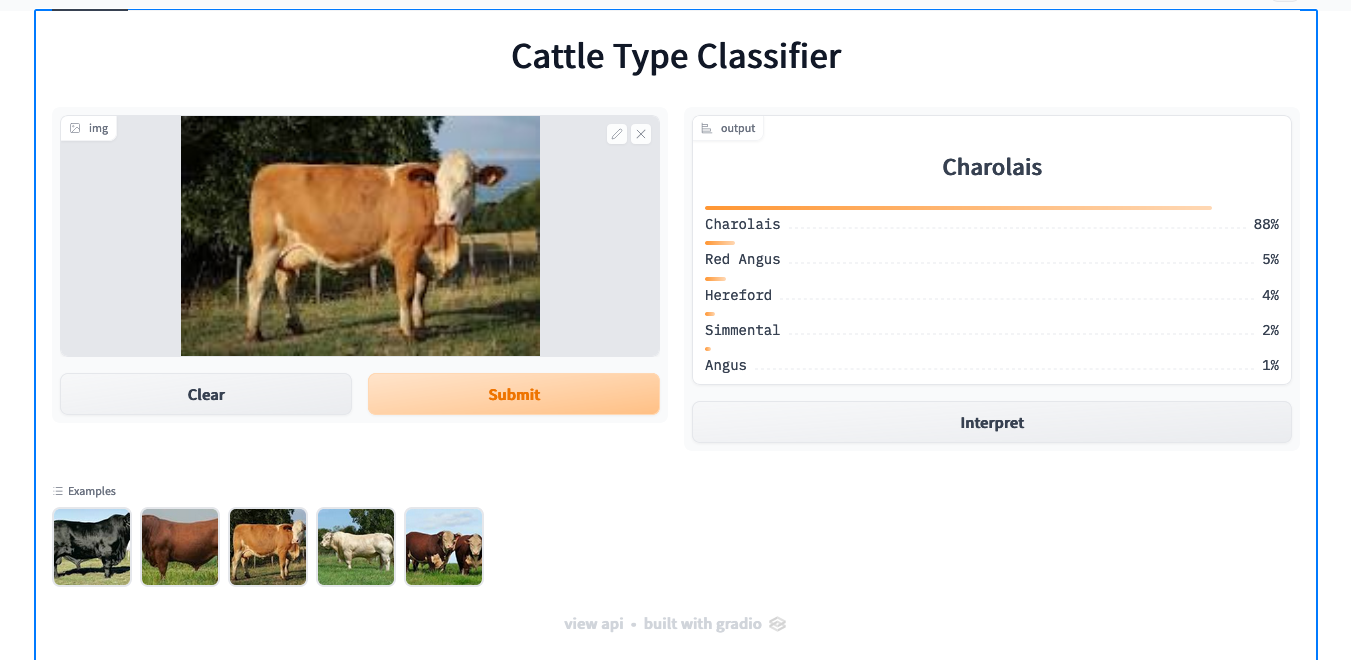

Modelo disponível no link: https://huggingface.co/spaces/DanielViniciusAlves/AM_Lesson2